## WTK Data Preparation

Caleb Phillips (caleb.phillips@nrel.gov), Dmitry Duplyakin (dmitry.duplyakin@nrel.gov) and Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov)

The purpose of this notebook is to read in WTK and WTK-LED data at the turbine locations (the entire time period available, spatially and vertically interpolated).

Notes: 
Might need to install Rex if it isn't installed already:
conda install nrel-rex --channel=nrel

More about rex: https://github.com/NREL/rex
2018 5-min monthly h5 (the file you referenced on the 21st):
/campaign/tap/CONUS/wtk/5min/2018/{month}/conus_2018-{month}.h5
 
2018 5-min yearly h5 slices:
/shared-projects/wtk-led/CONUS/wtk/2018/yearly_h5/conus_2018_{height}m.h5
 
2019 60-min yearly h5:
/campaign/tap/CONUS/wtk/60min/2019/conus_2019.h5

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import h5pyd
from rex.resource_extraction import MultiYearWindX
from dw_tap.data_fetching import get_data_wtk_led_on_eagle 
from dw_tap.data_fetching import getData

from tqdm import tqdm

from site_index import SiteIndex

#Added for OneEnergy
from site_index_oe import SiteIndexOE

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read in index of turbines

If running just the windtoolkit code, you only need this not the next two sections.

In [2]:
#Bergey
index = SiteIndex()

#One Energy
#index = SiteIndexOE()

index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
0,t007,A2744,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary,6.55,24828
1,t024,A2690,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,5.86,19184
2,t028,A2672,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
3,t034,A3685,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public,6.55,24828
4,t041,A3933,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN,5.94,19829


In [30]:
#index_selected = index.index[index.index["APRS ID"].apply(lambda x: x in ["t169", "t221", "t207"])]
index_selected = index.index[index.index["APRS ID"].apply(lambda x: x in ["t028", "t182", "t140", "t169", "t221", "t207"])]
index_selected

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
2,t028,A2672,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
11,t140,A3679,Amagansett,Amagansett Fire Department,NY,40.979107,-72.136609,37,QL2,2014.0,...,"Partial, some missing",Bergey Excel 10 (repowered in 2021 to a Bergey...,2013/01 - 2016/12,ny_brookhaven.qc.csv,40.870731,-72.888835,50.0,Public,6.44,23935
12,t169,A3835,Fort Wayne,Indiana Tech,IN,41.076813,-85.116974,37,QL2,2017.0,...,"Good, few missing",Bergey Excel 10,2013/01 - 2020/12,NaN,NaN,NaN,NaN,NaN,4.71,10812
14,t182,A3498,LaFargeville,LaFargeville Central School,NY,44.192569,-75.964895,37,QL2,2014.0,...,"Good, few missing",Bergey Excel 10,2012/01 - 2021/12,NaN,NaN,NaN,NaN,NaN,5.41,15681
17,t207,A2723,Richton Park,Richton Park,IL,41.483590,-87.723669,37,QL1,2017.0,...,Good coverage,Bergey Excel 10,2013/01 - 2013/12,il_pioneertrail.PROPRIETARY.pruf.csv,40.487000,-88.050000,48.0,Proprietary,5.50,16357
18,t221,A2671,Cedar Falls,University of Northern Iowa,IA,42.510051,-92.457860,30,QL2,2020.0,...,Good coverage,Bergey Excel 10,2012/01 - 2019/12,NaN,NaN,NaN,NaN,NaN,5.37,15381


### Fetch Wind Toolkit Data

In [32]:
consider_heights_above_turbine = [40,50,60,70,80]

In [33]:
# Open the wind data "file"
# server endpoint, username, password are found in ~/.hscfg
f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

def fetch_dfs(index,wtk_dfs=[]):
    for row in tqdm(index.itertuples()):
        tid = row[1]
        lat = row[6]
        lon = row[7]
        z_turbine = row[8]
        
        for z in [z_turbine] + consider_heights_above_turbine:
            
            # avoid re-running things that have already run
            #if tid in [x['tid'][0] for x in wtk_dfs]:
            #    print("Skipping "+str(tid))
            #    continue
            
            print("Fetching data for tid: %s, z: %.2f" % (tid, z))
            atmospheric_df = getData(f, lat, lon, z, "IDW", 
                                     power_estimate=False,
                                     inverse_monin_obukhov_length=False,
                                     start_time_idx=0, end_time_idx=8760, time_stride=1)
            atmospheric_df['tid'] = tid
            atmospheric_df['height'] = z
            wtk_dfs.append(atmospheric_df)
            
    return wtk_dfs

# in case HSDS has a connection error we will try a second time
try:
    wtk_dfs = fetch_dfs(index_selected)
except ConnectionError:
    print("Caught a connection error, trying to resume...")
    wtk_dfs = fetch_dfs(indx,wtk_dfs)

0it [00:00, ?it/s]

Fetching data for tid: t028, z: 30.00
Fetching data for tid: t028, z: 40.00
Fetching data for tid: t028, z: 50.00
Fetching data for tid: t028, z: 60.00
Fetching data for tid: t028, z: 70.00
Fetching data for tid: t028, z: 80.00


1it [01:10, 70.61s/it]

Fetching data for tid: t140, z: 37.00
Fetching data for tid: t140, z: 40.00
Fetching data for tid: t140, z: 50.00
Fetching data for tid: t140, z: 60.00
Fetching data for tid: t140, z: 70.00
Fetching data for tid: t140, z: 80.00


2it [02:21, 70.62s/it]

Fetching data for tid: t169, z: 37.00
Fetching data for tid: t169, z: 40.00
Fetching data for tid: t169, z: 50.00
Fetching data for tid: t169, z: 60.00
Fetching data for tid: t169, z: 70.00
Fetching data for tid: t169, z: 80.00


3it [03:27, 68.76s/it]

Fetching data for tid: t182, z: 37.00
Fetching data for tid: t182, z: 40.00
Fetching data for tid: t182, z: 50.00
Fetching data for tid: t182, z: 60.00
Fetching data for tid: t182, z: 70.00
Fetching data for tid: t182, z: 80.00


4it [04:38, 69.54s/it]

Fetching data for tid: t207, z: 37.00
Fetching data for tid: t207, z: 40.00
Fetching data for tid: t207, z: 50.00
Fetching data for tid: t207, z: 60.00
Fetching data for tid: t207, z: 70.00
Fetching data for tid: t207, z: 80.00


5it [05:46, 68.81s/it]

Fetching data for tid: t221, z: 30.00
Fetching data for tid: t221, z: 40.00
Fetching data for tid: t221, z: 50.00
Fetching data for tid: t221, z: 60.00
Fetching data for tid: t221, z: 70.00
Fetching data for tid: t221, z: 80.00


6it [06:58, 69.81s/it]


In [34]:
wtk_df = pd.concat(wtk_dfs)

In [35]:
wtk_df

,datetime,ws,wd,tid,height
0,2007-01-01 00:00:00,4.232860,138.813965,t028,30
1,2007-01-01 01:00:00,3.994417,129.226991,t028,30
2,2007-01-01 02:00:00,4.086718,127.780017,t028,30
3,2007-01-01 03:00:00,4.688806,127.827337,t028,30
4,2007-01-01 04:00:00,4.861669,126.634669,t028,30
...,...,...,...,...,...
8756,2007-12-31 20:00:00,3.281388,320.039351,t221,80
8757,2007-12-31 21:00:00,5.455038,323.479620,t221,80
8758,2007-12-31 22:00:00,6.946956,319.548485,t221,80
8759,2007-12-31 23:00:00,8.232996,322.721305,t221,80


In [36]:
wtk_df['packet_date'] = pd.to_datetime(wtk_df["datetime"]).dt.tz_localize('UTC')

#One Energy
wtk_df.to_csv("01 Bergey RH_analysis/wtk.csv.bz2",index=False)

In [44]:
grouped_avg = wtk_df[["tid", "height", "ws"]].groupby(["tid", "height"]).apply(np.mean)[["ws"]]
grouped_avg

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


ws
tid  height          
t028 30      4.635459
     40      4.888773
     50      5.152565
     60      5.424354
     70      5.702100
     80      5.984374
t140 37      6.387830
     40      6.494037
     50      6.849544
     60      7.206864
     70      7.565633
     80      7.925589
t169 37      5.154491
     40      5.259457
     50      5.614671
     60      5.975918
     70      6.341324
     80      6.709756
t182 37      4.961702
     40      5.064457
     50      5.417456
     60      5.786857
     70      6.165395
     80      6.550170
t207 37      5.807759
     40      5.904123
     50      6.231710
     60      6.573847
     70      6.921320
     80      7.271708
t221 30      5.267752
     40      5.597366
     50      5.942961
     60      6.313760
     70      6.693422
     80      7.077427

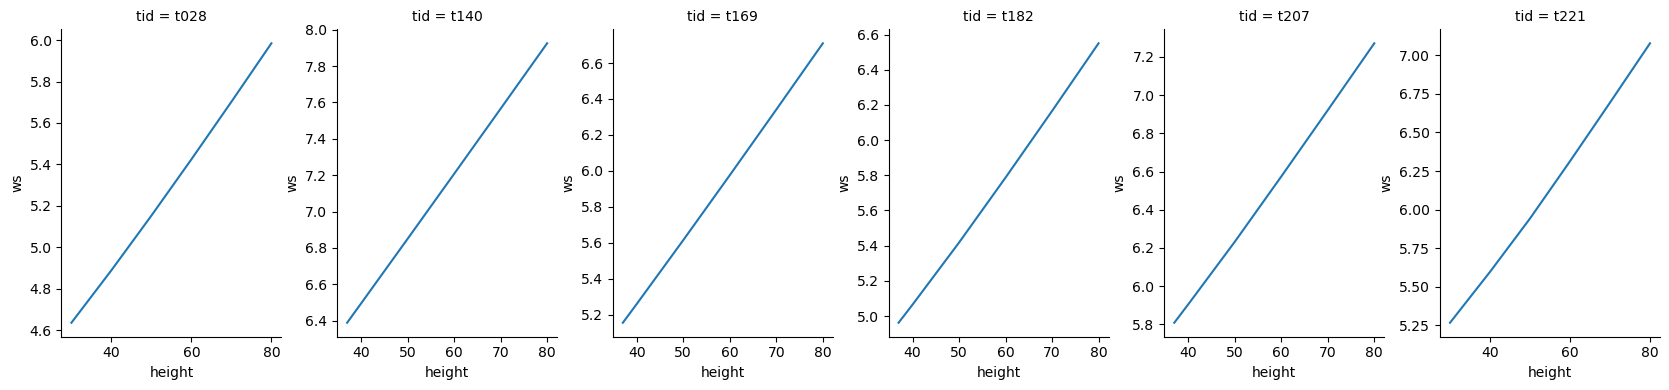

In [45]:
import seaborn as sns
sns.relplot(
    data=grouped_avg,
    x="height", y="ws",
    col="tid",
    kind="line",
    height=4, aspect=0.7, facet_kws=dict(sharex=False, sharey=False),
)